In [4]:
# Cell 1 - Title and short description
print("Fake News Detection - TF-IDF + Logistic Regression")
print("Dataset: Kaggle 'Fake and Real News Dataset'. Place Fake.csv and True.csv in the same folder.")


Fake News Detection - TF-IDF + Logistic Regression
Dataset: Kaggle 'Fake and Real News Dataset'. Place Fake.csv and True.csv in the same folder.


In [5]:
# Cell 2 - Imports
# Explanation: import standard libraries and sklearn modules we'll use.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import re
import string


In [6]:
# Cell 3 - Load dataset
# Explanation: we load both CSVs and create a combined dataframe with a 'label' column:
# label=1 for REAL, label=0 for FAKE (choose as you prefer)
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

print("Fake shape:", fake.shape)
print("True shape:", true.shape)

# add label and unify columns (some datasets use title/text)
fake['label'] = 0
true['label'] = 1

# The clmentbisaillon dataset has columns: title, text. We'll combine title+text as 'content'
fake['content'] = fake['title'].fillna('') + " " + fake['text'].fillna('')
true['content'] = true['title'].fillna('') + " " + true['text'].fillna('')

df = pd.concat([fake[['content','label']], true[['content','label']]], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined dataset shape:", df.shape)
df.head()


Fake shape: (23481, 4)
True shape: (21417, 4)
Combined dataset shape: (44898, 2)


,content,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64


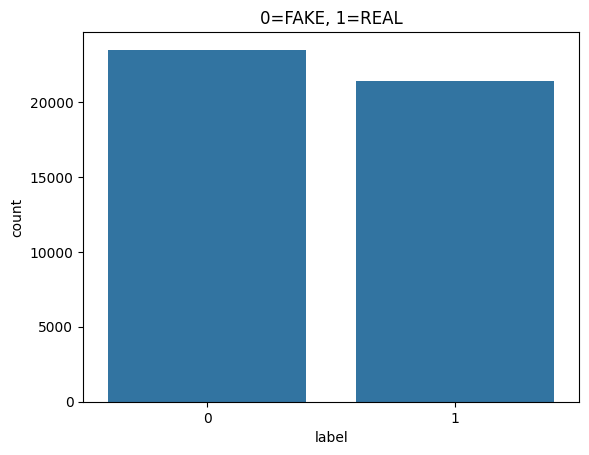

In [7]:
# Cell 4 - Quick EDA
print("Label distribution:")
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("0=FAKE, 1=REAL")
plt.show()


In [8]:
# Cell 5 - Text cleaning function (simple)
# Explanation: remove URLs, HTML, punctuation, lowercase. Keep it simple for TF-IDF.
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'<.*?>', '', text)               # remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)          # keep letters only
    text = text.lower()                             # lowercase
    text = text.strip()
    return ' '.join(text.split())

df['clean'] = df['content'].apply(clean_text)
df['clean'].head()


0    ben stein calls out th circuit court committed...
1    trump drops steve bannon from national securit...
2    puerto rico expects u s to lift jones act ship...
3    oops trump just accidentally confirmed he leak...
4    donald trump heads for scotland to reopen a go...
Name: clean, dtype: object

In [9]:
# Cell 6 - Train/test split
# Explanation: split the cleaned text and labels into train/test
X = df['clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (35918,) Test: (8980,)


In [10]:
# Cell 7 - TF-IDF vectorization
# Explanation: We'll use TF-IDF with uni-grams & bi-grams and a max_features cap to control size.
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (35918, 50000)


Logistic Regression performance:
Accuracy: 0.9881959910913141
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



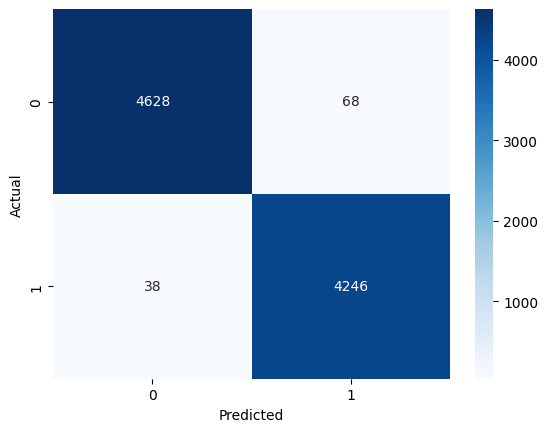

In [11]:
# Cell 8 - Train Logistic Regression
# Explanation: Logistic Regression is fast and interpretable. We'll also show alternative models.
lr = LogisticRegression(max_iter=1000, C=1.0, solver='saga', n_jobs=-1, random_state=42)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print("Logistic Regression performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


In [12]:
# Cell 9 - Optional: try MultinomialNB and RandomForest quickly (compare)
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
print("NB accuracy:", accuracy_score(y_test, nb.predict(X_test_tfidf)))

rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
# RandomForest might be slower; you can try with a smaller sample if dataset is large
# rf.fit(X_train_tfidf, y_train)
# print("RF accuracy:", accuracy_score(y_test, rf.predict(X_test_tfidf)))


NB accuracy: 0.9571269487750557


In [14]:
# Cell 10 - Save model & vectorizer
joblib.dump(lr, "tfidf_logreg_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
print("Saved model and vectorizer as tfidf_logreg_model.joblib and tfidf_vectorizer.joblib")


Saved model and vectorizer as tfidf_logreg_model.joblib and tfidf_vectorizer.joblib


In [15]:
# Cell 11 - Small utility: function to predict single article (returns label + prob)
def predict_text(text, model=lr, vectorizer=vectorizer):
    text_clean = clean_text(text)
    tfidf = vectorizer.transform([text_clean])
    prob = model.predict_proba(tfidf)[0]
    label = model.predict(tfidf)[0]
    return label, prob

# Example
sample = X_test.sample(1, random_state=10).values[0]
label, prob = predict_text(sample)
print("Sample predicted label:", label, "prob:", prob)


Sample predicted label: 0 prob: [0.94797937 0.05202063]


In [16]:
# Cell 12 - Explainability shortcut: show top positive/negative words for logistic regression
# Explanation: We can look at the logistic regression coefficients for interpretability.
feature_names = vectorizer.get_feature_names_out()
coefs = lr.coef_[0]
top_pos = np.argsort(coefs)[-20:][::-1]
top_neg = np.argsort(coefs)[:20]

print("Top words indicating REAL:")
for idx in top_pos[:20]:
    print(feature_names[idx], f"{coefs[idx]:.4f}")

print("\nTop words indicating FAKE:")
for idx in top_neg[:20]:
    print(feature_names[idx], f"{coefs[idx]:.4f}")


Top words indicating REAL:
reuters 22.6060
said 17.7047
washington reuters 9.3139
president donald 5.3593
republican 5.0946
wednesday 5.0811
washington 5.0108
reuters president 4.7592
tuesday 4.7297
thursday 4.4654
friday 4.0470
minister 3.9209
monday 3.7967
nov 3.5625
presidential 3.3985
said statement 3.3514
democratic 3.1045
spokesman 2.9931
comment 2.9521
president barack 2.9070

Top words indicating FAKE:
video -10.0000
just -6.9505
hillary -5.7561
president trump -5.3856
gop -5.3563
image -5.2849
featured image -5.2001
read -5.1973
featured -5.1407
obama -4.9003
watch -4.6341
america -4.6085
wire -4.5396
mr -4.3733
like -3.9499
getty -3.7480
com -3.6615
getty images -3.6281
american -3.6094
breaking -3.4899


In [17]:
# Cell 13 - Save a small test csv example for streamlit usage (optional)
test_df = pd.DataFrame({"text": X_test.sample(10, random_state=1).values, "label": y_test.sample(10, random_state=1).values})
test_df.to_csv("sample_test_for_streamlit.csv", index=False)
print("Sample CSV saved as sample_test_for_streamlit.csv")


Sample CSV saved as sample_test_for_streamlit.csv


In [21]:
# Step 1: Vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=50000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 2: Train the model
model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, random_state=42)
model.fit(X_train_tfidf, y_train)

print("✅ Model trained successfully!")


✅ Model trained successfully!


In [22]:
import joblib

# Save model and vectorizer
joblib.dump(model, "tfidf_logreg_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!
